#Building an image retrieval system with deep features


#Fire up GraphLab Create

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sklearn, pandas
import numpy as np

#Load the CIFAR-10 dataset

We will use a popular benchmark dataset in computer vision called CIFAR-10.  

(We've reduced the data to just 4 categories = {'cat','bird','automobile','dog'}.)

This dataset is already split into a training set and test set. In this simple retrieval example, there is no notion of "testing", so we will only use the training data.

In [4]:
image_train = pandas.read_csv('/content/drive/MyDrive/FUNIX Labs/Lab 14/image_train_data.csv')
#image_test = pandas.read_csv('/content/drive/MyDrive/FUNIX Labs/Lab 14/image_test_data.csv')

In [5]:
import itertools, io
def convert_features(img):
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.float16)
    stringbuf.close()
    return array
def variable_length_to_2d(series):
    return np.array(list(itertools.zip_longest(*series.values, fillvalue=0))).T
image_train['deep_np'] = image_train['deep_features'].map(convert_features)
train_data = variable_length_to_2d(image_train['deep_np'])

In [6]:
def convert_img(img): 
    stringbuf = io.StringIO(img[1:-1])
    array = np.loadtxt(stringbuf, dtype=np.uint8)
    stringbuf.close()
    return array
image_train['image_np'] = image_train['image_array'].map(convert_img)

#Computing deep features for our images

The two lines below allow us to compute deep features.  This computation takes a little while, so we have already computed them and saved the results as a column in the data you loaded. 

(Note that if you would like to compute such deep features and have a GPU on your machine, you should use the GPU enabled GraphLab Create, which will be significantly faster for this task.)

In [7]:
#deep_learning_model = graphlab.load_model('http://s3.amazonaws.com/GraphLab-Datasets/deeplearning/imagenet_model_iter45')
#image_train['deep_features'] = deep_learning_model.extract_features(image_train)

In [8]:
image_train.head()

,id,image,label,deep_features,image_array,deep_np,image_np
0,24,Height: 32 Width: 32,bird,[0.242872 1.09545 0 0.39363 0 0 11.8949 0 0 0 ...,[73 77 58 71 68 50 77 69 44 120 116 83 125 120...,"[0.2429, 1.096, 0.0, 0.3936, 0.0, 0.0, 11.9, 0...","[73, 77, 58, 71, 68, 50, 77, 69, 44, 120, 116,..."
1,33,Height: 32 Width: 32,cat,[0.525088 0 0 0 0 0 9.94829 0 0 0 0 0 1.01264 ...,[7 5 8 7 5 8 5 4 6 7 4 7 11 5 9 11 5 9 17 11 1...,"[0.525, 0.0, 0.0, 0.0, 0.0, 0.0, 9.945, 0.0, 0...","[7, 5, 8, 7, 5, 8, 5, 4, 6, 7, 4, 7, 11, 5, 9,..."
2,36,Height: 32 Width: 32,cat,[0.566016 0 0 0 0 0 9.9972 0 0 0 1.38345 0 0.7...,[169 122 65 131 108 75 193 196 192 218 221 222...,"[0.566, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0....","[169, 122, 65, 131, 108, 75, 193, 196, 192, 21..."
3,70,Height: 32 Width: 32,dog,[1.1298 0 0 0.778194 0 0.758051 9.83053 0 0 0....,[154 179 152 159 183 157 165 189 162 174 199 1...,"[1.13, 0.0, 0.0, 0.7783, 0.0, 0.758, 9.83, 0.0...","[154, 179, 152, 159, 183, 157, 165, 189, 162, ..."
4,90,Height: 32 Width: 32,bird,[1.71787 0 0 0 0 0 9.33936 0 0 0 0 0 0.412137 ...,[216 195 180 201 178 160 210 184 164 212 188 1...,"[1.718, 0.0, 0.0, 0.0, 0.0, 0.0, 9.336, 0.0, 0...","[216, 195, 180, 201, 178, 160, 210, 184, 164, ..."


#Train a nearest-neighbors model for retrieving images using deep features

We will now build a simple image retrieval system that finds the nearest neighbors for any image.

In [9]:
#knn_model = graphlab.nearest_neighbors.create(image_train,features=['deep_features'],
#                                             label='id')
from sklearn.neighbors import NearestNeighbors
knn_model = NearestNeighbors()
knn_model.fit(train_data)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#Use image retrieval model with deep features to find similar images

Let's find similar images to this cat picture.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_image(image_data, dimension=(32, 32, 3)):
    image = np.reshape(image_data, dimension)
    plt.axis('off')
    plt.imshow(image)       
    
def show_images(images, cols=3):
    rows = len(images) // cols + ( 0 if len(images) % cols == 0 else 1)
    fig = plt.figure(figsize=(cols, rows))
    for i, img_data in enumerate(images):
        #i_row, i_col = i % cols, i // cols
        fig.add_subplot(rows, cols, i+1)
        show_image(img_data)

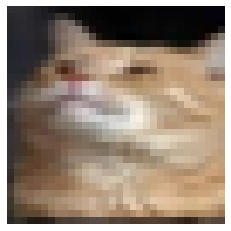

In [11]:
#graphlab.canvas.set_target('ipynb')
cat = image_train[18:19]
#print(cat['image_np'].values)
show_image(cat['image_np'].values[0])

In [12]:
# we want 5 closest, so 6 and remove itself
cat_neighbors = knn_model.kneighbors(variable_length_to_2d(cat['deep_np']), n_neighbors=6)[1][0][1:]

We are going to create a simple function to view the nearest neighbors to save typing:

In [13]:
def get_data_from_ids(query_result):
    return image_train.iloc[query_result]
    #return image_train.filter_by(query_result['reference_label'],'id')

In [14]:
cat_neighbors_queried = get_data_from_ids(cat_neighbors)
cat_neighbors_queried

,id,image,label,deep_features,image_array,deep_np,image_np
288,6910,Height: 32 Width: 32,cat,[1.55475 0 0 0 0 0 10.1923 0 0 0 0 0 0.793507 ...,[154 133 92 134 112 75 108 87 53 98 78 45 104 ...,"[1.555, 0.0, 0.0, 0.0, 0.0, 0.0, 10.195, 0.0, ...","[154, 133, 92, 134, 112, 75, 108, 87, 53, 98, ..."
1565,39777,Height: 32 Width: 32,cat,[0 0 0 0 0 0 9.42072 0 0 0 0 0 1.15609 0 0 0.9...,[145 166 165 164 185 184 185 206 205 198 218 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.42, 0.0, 0.0,...","[145, 166, 165, 164, 185, 184, 185, 206, 205, ..."
1468,36870,Height: 32 Width: 32,cat,[0.240483 0 0 0 0 0 9.52754 0 0 0 0 0 1.56046 ...,[16 20 19 14 19 17 11 15 14 9 15 13 14 21 20 2...,"[0.2405, 0.0, 0.0, 0.0, 0.0, 0.0, 9.53, 0.0, 0...","[16, 20, 19, 14, 19, 17, 11, 15, 14, 9, 15, 13..."
1633,41734,Height: 32 Width: 32,cat,[0 0 0 0 0 0 11.6715 0 0 0 0 0 1.82079 0 0 0.5...,[122 27 34 120 24 31 119 21 29 120 19 28 121 1...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.67, 0.0, 0.0...","[122, 27, 34, 120, 24, 31, 119, 21, 29, 120, 1..."
207,5147,Height: 32 Width: 32,cat,[0 0 0.507177 0.97065 0 0 8.91446 0 0 0 0 0 1....,[167 164 153 75 63 45 84 69 49 88 76 57 90 75 ...,"[0.0, 0.0, 0.5073, 0.9707, 0.0, 0.0, 8.914, 0....","[167, 164, 153, 75, 63, 45, 84, 69, 49, 88, 76..."


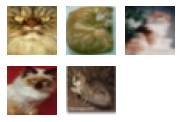

In [15]:
#cat_neighbors_queried['image']
show_images(cat_neighbors_queried['image_np'].values)

Very cool results showing similar cats.

##Finding similar images to a car

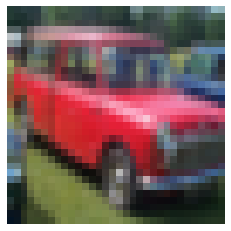

In [16]:
car = image_train[8:9]
show_image(car['image_np'].values[0])

In [17]:
car_neighbors = knn_model.kneighbors(variable_length_to_2d(car['deep_np']), n_neighbors=6)[1][0][1:]
#get_images_from_ids(car_neighbors)['image'].show()
get_data_from_ids(car_neighbors)

,id,image,label,deep_features,image_array,deep_np,image_np
372,8977,Height: 32 Width: 32,automobile,[0 0 0 0.136156 0 0 6.81498 0 0 0 0 0 0.437228...,[186 195 199 182 192 198 184 196 203 178 190 1...,"[0.0, 0.0, 0.0, 0.1361, 0.0, 0.0, 6.816, 0.0, ...","[186, 195, 199, 182, 192, 198, 184, 196, 203, ..."
1757,44395,Height: 32 Width: 32,automobile,[0 0 0 1.34758 0 0 7.38394 0 0 0 0 0 0.860271 ...,[89 95 50 83 84 43 69 70 42 64 69 39 55 63 29 ...,"[0.0, 0.0, 0.0, 1.348, 0.0, 0.0, 7.383, 0.0, 0...","[89, 95, 50, 83, 84, 43, 69, 70, 42, 64, 69, 3..."
1343,33261,Height: 32 Width: 32,automobile,[0 0 0 0 0 0.157148 6.90395 0 0 0 1.25121 0 0....,[110 118 104 98 104 80 92 100 68 95 110 60 112...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1571, 6.902, 0.0, ...","[110, 118, 104, 98, 104, 80, 92, 100, 68, 95, ..."
1009,24146,Height: 32 Width: 32,automobile,[0 0 0 0 0 0 9.21664 0 0 0 0 0 0.291935 0 0 0....,[229 231 227 232 235 231 231 235 230 233 237 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0,...","[229, 231, 227, 232, 235, 231, 231, 235, 230, ..."
1840,46240,Height: 32 Width: 32,automobile,[0 0.643995 0 0 0 0 6.92689 0 0 0 2.34283 0 1....,[161 186 232 155 174 211 142 165 206 153 179 2...,"[0.0, 0.644, 0.0, 0.0, 0.0, 0.0, 6.926, 0.0, 0...","[161, 186, 232, 155, 174, 211, 142, 165, 206, ..."


#Just for fun, let's create a lambda to find and show nearest neighbor images

In [18]:
def show_neighbors(idx, n_neighbors=5):
    neighbors = knn_model.kneighbors(train_data[idx:idx+1], n_neighbors=n_neighbors+1)[1][0][1:]
    neighbors_queried = get_data_from_ids(neighbors)
    return neighbors_queried

In [19]:
test_8 = show_neighbors(8)
test_8

,id,image,label,deep_features,image_array,deep_np,image_np
372,8977,Height: 32 Width: 32,automobile,[0 0 0 0.136156 0 0 6.81498 0 0 0 0 0 0.437228...,[186 195 199 182 192 198 184 196 203 178 190 1...,"[0.0, 0.0, 0.0, 0.1361, 0.0, 0.0, 6.816, 0.0, ...","[186, 195, 199, 182, 192, 198, 184, 196, 203, ..."
1757,44395,Height: 32 Width: 32,automobile,[0 0 0 1.34758 0 0 7.38394 0 0 0 0 0 0.860271 ...,[89 95 50 83 84 43 69 70 42 64 69 39 55 63 29 ...,"[0.0, 0.0, 0.0, 1.348, 0.0, 0.0, 7.383, 0.0, 0...","[89, 95, 50, 83, 84, 43, 69, 70, 42, 64, 69, 3..."
1343,33261,Height: 32 Width: 32,automobile,[0 0 0 0 0 0.157148 6.90395 0 0 0 1.25121 0 0....,[110 118 104 98 104 80 92 100 68 95 110 60 112...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.1571, 6.902, 0.0, ...","[110, 118, 104, 98, 104, 80, 92, 100, 68, 95, ..."
1009,24146,Height: 32 Width: 32,automobile,[0 0 0 0 0 0 9.21664 0 0 0 0 0 0.291935 0 0 0....,[229 231 227 232 235 231 231 235 230 233 237 2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.22, 0.0, 0.0,...","[229, 231, 227, 232, 235, 231, 231, 235, 230, ..."
1840,46240,Height: 32 Width: 32,automobile,[0 0.643995 0 0 0 0 6.92689 0 0 0 2.34283 0 1....,[161 186 232 155 174 211 142 165 206 153 179 2...,"[0.0, 0.644, 0.0, 0.0, 0.0, 0.0, 6.926, 0.0, 0...","[161, 186, 232, 155, 174, 211, 142, 165, 206, ..."


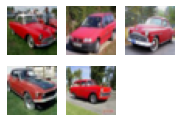

In [20]:
show_images(test_8['image_np'].values)

In [21]:
test_26 = show_neighbors(26)
test_26

,id,image,label,deep_features,image_array,deep_np,image_np
457,11000,Height: 32 Width: 32,automobile,[0 0.26031 0 0 0 0.23388 10.0011 0 0 0 0.18946...,[255 255 255 219 222 229 167 171 185 170 174 1...,"[0.0, 0.2603, 0.0, 0.0, 0.0, 0.2339, 10.0, 0.0...","[255, 255, 255, 219, 222, 229, 167, 171, 185, ..."
377,9118,Height: 32 Width: 32,automobile,[0.914692 0 0 0 0 0 9.96389 0 0 0 0.127803 0 2...,[107 117 133 98 107 114 113 121 120 124 128 12...,"[0.9146, 0.0, 0.0, 0.0, 0.0, 0.0, 9.96, 0.0, 0...","[107, 117, 133, 98, 107, 114, 113, 121, 120, 1..."
1576,40118,Height: 32 Width: 32,automobile,[0.3851 0.0709699 0 0 0 0 8.91591 0 0 0 0 0 0....,[157 145 124 154 143 121 163 147 123 163 144 1...,"[0.385, 0.071, 0.0, 0.0, 0.0, 0.0, 8.914, 0.0,...","[157, 145, 124, 154, 143, 121, 163, 147, 123, ..."
1280,31776,Height: 32 Width: 32,automobile,[0.767597 0.517459 0 0 0 0 9.75294 0 0 0 0.525...,[139 149 118 140 148 119 156 166 128 113 119 9...,"[0.7676, 0.5176, 0.0, 0.0, 0.0, 0.0, 9.75, 0.0...","[139, 149, 118, 140, 148, 119, 156, 166, 128, ..."
990,23662,Height: 32 Width: 32,automobile,[0.104303 0 0 0 0 0.804265 9.38957 0 0 0 0.052...,[176 175 172 174 174 169 179 179 175 165 166 1...,"[0.1043, 0.0, 0.0, 0.0, 0.0, 0.804, 9.39, 0.0,...","[176, 175, 172, 174, 174, 169, 179, 179, 175, ..."


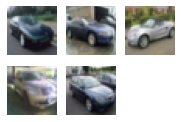

In [22]:
show_images(test_26['image_np'].values)